In [1]:
# import library
import shapefile
import rasterio
import cv2
from scipy import spatial
from scipy import ndimage as ndi
from skimage import io,filters,util,color,img_as_ubyte,img_as_uint
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import disk, dilation, erosion, remove_small_objects
from skimage.measure import regionprops
from skimage.feature import greycomatrix,greycoprops
import math
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Perspective transform, the image to the positive
def transform(chm_path, RTK_information_path):
    sf = shapefile.Reader(RTK_information_path,'rb')
    shapes = sf.shapes()
    list_p = []
    num=0
    for i in shapes:
        list_p.append(shapes[num].points[0])
        num+=1   
    dataset = rasterio.open(chm_path)
    # Convert geographic coordinates to pixel coordinates
    upper_left_x, upper_left_y = (list_p[0][0],list_p[0][1])
    upper_left_row, upper_left_col = dataset.index(upper_left_x, upper_left_y)
    lower_left_x, lower_left_y = (list_p[1][0],list_p[1][1])
    lower_left_row, lower_left_col = dataset.index(lower_left_x, lower_left_y)
    upper_right_x, upper_right_y = (list_p[3][0],list_p[3][1])
    upper_right_row, upper_right_col = dataset.index(upper_right_x, upper_right_y)
    lower_right_x, lower_right_y = (list_p[2][0],list_p[2][1])
    lower_right_row, lower_right_col = dataset.index(lower_right_x, lower_right_y)
    columns_1 = np.int64(math.sqrt((upper_left_row-lower_left_row)**2
                                  + (upper_left_col-lower_left_col)**2))
    columns_2 = np.int64(math.sqrt((upper_right_row-lower_right_row)**2
                                  + (upper_right_col-lower_right_col)**2))
    columns_val = np.max((columns_1,columns_2))
    columns_val_base = columns_val-30
    rows_1 = np.int64(math.sqrt((upper_left_row-upper_right_row)**2
                               + (upper_left_col-upper_right_col)**2))
    rows_2 = np.int64(math.sqrt((lower_left_row-lower_right_row)**2
                               + (lower_left_col-lower_right_col)**2))
    rows_val = np.max((rows_1,rows_2))
    rows_val_base = rows_val
    # PersPective Transformation
    img_tif = io.imread(chm_path)
    pts1 = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                           [lower_right_col,lower_right_row]])
    pts2 = np.float32([[0,0],[rows_val,0],[0,columns_val],[rows_val,columns_val]])
    M_PT = cv2.getPerspectiveTransform(pts1,pts2)
    dst_PT = cv2.warpPerspective(img_tif,M_PT,(rows_val,columns_val))
    
    #visualization 
    fig, ax = plt.subplots(figsize=(10,10))
    plt.axis('off')
    ax.imshow(dst_PT,plt.cm.gray)
    
    return dst_PT, columns_val, rows_val, columns_val_base, rows_val_base

In [3]:
# binaryzation
# Add inner cycle parameter - size of etched kernel, kernel size
def binaryzation(dst_PT):
    ero_all = []
    kernel_size = [5,8,26]
    for size in range(len(kernel_size)):
        thresh = filters.threshold_isodata(dst_PT)
        dst_th =(dst_PT <= thresh)*1.0    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size[size], kernel_size[size]))
        ero = cv2.erode(dst_th,kernel,iterations = 1)
        ero_all.append(ero)
        
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(dst_PT,plt.cm.gray)
    ax[1].imshow(ero_all[0],plt.cm.gray)
    ax[2].imshow(ero_all[1],plt.cm.gray)
    ax[3].imshow(ero_all[2],plt.cm.gray)
    plt.tight_layout()
    plt.show()
    return ero_all

In [5]:
# Detect and filter horizontal lines
def line_horizontal(dst_PT, ero_all):    
    # Filter horizontal line
    def line_merge_h(lines,dif):
        lines.sort()
        cons = []
        for i in range(len(lines)-1):
            if lines[i+1] - lines[i] < dif:
                avg = lines[i]
                cons.append(avg)     
            elif lines[i] - lines[i-1] >= dif and i != 0:
                cons.append(lines[i])
            elif i == 0:
                cons.append(lines[i])
        if lines[-1] - lines[-2] >= dif:
            cons.append(lines[-1])
        return cons
    
    # The Hough transform detects horizontal lines
    hough_h_m_all = []
    hor_cons_all = []
    hor_cons_num = []
    height,width = dst_PT.shape[:2]
    for i in range(len(ero_all)):
        hough_bw_h = np.zeros((height,width))

        tested_angles = np.linspace(np.pi / 2, np.pi / 2, 10)
        h, theta, d = hough_line(ero_all[i], theta=tested_angles)
        _, angle, dist=hough_line_peaks(h, theta, d)

        d_sort=np.sort(dist)
        d_dif = np.diff(d_sort)
        d_dif_max_h = d_dif.max()*0.65
        
        origin = np.array((0, dst_PT.shape[1]))
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
            y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
            cv2.line(hough_bw_h,(0, int(y0)),(width, int(y1)),255,6)

        hough_bw_h = np.bitwise_not(hough_bw_h.astype("uint8"))
        hough_h_inv=util.invert(hough_bw_h)
    
        # Filter horizontal line
        lines_h = cv2.HoughLines(hough_h_inv.astype("uint8"),1,np.pi/90,100)
        hor = []
        for line in lines_h:
            if line[0][1] > 1.55 and line[0][1] < 1.58:
                hor.append(line[0,0])       
        hor.sort()
        hor_cons = []
        while len(hor_cons) != len(hor):
            hor_cons = hor
            hor = line_merge_h(hor,d_dif_max_h)
        hor_cons_num.append(len(hor_cons))
        hor_cons_all.append(hor_cons)

        hough_h_m = np.zeros((height,width))
        for i in hor_cons:
            cv2.line(hough_h_m,(0, int(i)),(width, int(i)),255,1)

        hough_h_m = np.bitwise_not(hough_h_m.astype("uint8"))
        hough_h_m = util.invert(hough_h_m) #筛选后的水平线
        hough_h_m_all.append(hough_h_m)

    se = hor_cons_num.index(max(hor_cons_num))
    hor_cons_se = hor_cons_all[se]
    hough_h_se = hough_h_m_all[se]
    
    
    # visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(dst_PT, plt.cm.gray)
    origin = np.array((0, dst_PT.shape[1]))
    origin_0 = np.array((0, dst_PT.shape[0]))
    for j in hor_cons_se:
        ax.plot(origin,(j,j),'-r',6)
    ax.set_xlim(origin)
    ax.set_ylim((dst_PT.shape[0], 0))
    ax.set_axis_off()
    ax.set_title('Detected lines')
    
    return hough_h_se, hor_cons_se

In [6]:
# Add a horizontal base line
def base_line_horizontal(dst_PT, hor_cons_se, column_number,columns_val_base):
    # Add a horizontal base line according to the number of rows
    blank_img = np.zeros((dst_PT.shape[0],dst_PT.shape[1]))
    h_value = (columns_val_base)/column_number
    h_line_base = blank_img.copy()
    h_line_rgb = np.zeros((dst_PT.shape[0],dst_PT.shape[1],3),np.uint8)
    inds_y_h = dst_PT.shape[1]-1
    inds_x_h = np.arange(30, len(h_line_base)-40, int(h_value))
    h_line_base[inds_x_h, :inds_y_h] = 1
    for i in inds_x_h:
        cv2.line(h_line_rgb,(0, i),(inds_y_h, i),(255,255,0),6)
    lines_h_base = cv2.HoughLines(h_line_base.astype("uint8"),1,np.pi/90,100)
    hor_base = []
    for line in lines_h_base:
        if line[0][1] > 1.55 and line[0][1] < 1.58:
            hor_base.append(line[0,0])
    
    # Merge and visualization of lines detected by Hough transform
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(h_line_rgb)
    ax[0].set_axis_off()
    ax[1].imshow(dst_PT,plt.cm.gray)
    origin = np.array((0, dst_PT.shape[1]))
    origin_0 = np.array((0, dst_PT.shape[0]))
    for i in hor_base:
        ax[1].plot(origin,(i,i),'-y',6)
    for j in hor_cons_se:
        ax[1].plot(origin,(j,j),'-r',6)
    ax[1].set_xlim(origin)
    ax[1].set_ylim((dst_PT.shape[0], 0))
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()
    
    return h_line_base, hor_base

In [7]:
# Vertical lines are detected and screened
def line_vertical(dst_PT, ero_all):
    #Filter the vertical lines
    def line_merge_v(lines,dif):
        lines.sort()
        cons = []
        for i in range(len(lines)-1):
            if lines[i+1] - lines[i] < dif:
                avg = lines[i]
                cons.append(avg)
            elif lines[i] - lines[i-1] >= dif and i != 0:
                cons.append(lines[i])
            elif i == 0:
                cons.append(lines[i])
        if lines[-1] - lines[-2] >=dif:
            cons.append(lines[-1])
        return cons
    
    # The Hough transform detects a vertical line
    hough_v_m_all = []
    ver_cons_all = []
    ver_cons_num = []
    height,width = dst_PT.shape[:2]
    for i in range(len(ero_all)):
        hough_bw_v = np.zeros((height,width))
        out = dst_PT.copy()
        lines_v_or = cv2.HoughLines(ero_all[i].astype("uint8"),0.1,np.pi/1,int(height*0.52))
        dist_v = []
        for line in lines_v_or:
            if line[0][1] > 0.01 and line[0][1] < 1.55:
                continue
            for rho,theta in line:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + height*(-b))
                y1 = int(y0 + height*(a))
                x2 = int(x0 - height*(-b))
                y2 = int(y0 - height*(a))
                dist_v.append(rho)
                cv2.line(out,(x1,y1),(x2,y2),(0,0,255),1)
                cv2.line(hough_bw_v,(x1,y1),(x2,y2),255,1)
        d_sort_v=np.sort(dist_v)
        d_dif_v = np.diff(d_sort_v)
        d_dif_max_v = d_dif_v.max()*0.45
        hough_bw_v = np.bitwise_not(hough_bw_v.astype("uint8"))
        hough_v_inv = util.invert(hough_bw_v)
        
        # Filter the vertical lines
        lines_v = cv2.HoughLines(hough_v_inv.astype("uint8"),1,np.pi/90,100)
        ver = []
        for line in lines_v:
            if line[0][1] < 0.01:
                ver.append(line[0,0])

        ver.sort()
        ver_cons = []
        while len(ver_cons) != len(ver):
            ver_cons = ver
            ver = line_merge_v(ver,d_dif_max_v)
        ver_cons_num.append(len(ver_cons))
        ver_cons_all.append(ver_cons)
        
        hough_v_m = np.zeros((height,width))

        for i in ver_cons:
            cv2.line(hough_v_m,(int(i),0),(int(i), height),255,1)

        hough_v_m = np.bitwise_not(hough_v_m.astype("uint8"))
        hough_v_m = util.invert(hough_v_m)
        hough_v_m_all.append(hough_v_m)
    
    se = ver_cons_num.index(np.median(ver_cons_num))
    ver_cons_se = ver_cons_all[se]
    hough_v_se = hough_v_m_all[se]
    
    # visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(dst_PT, plt.cm.gray)
    origin = np.array((0, dst_PT.shape[1]))
    origin_0 = np.array((0, dst_PT.shape[0]))
    for i in ver_cons_se:
        ax.plot((i,i),origin_0,'-r',6)
    ax.set_axis_off()
    ax.set_title('Detected lines')
    
    return hough_v_se, ver_cons_se

In [8]:
# Add a vertical reference line
def base_line_vertical(dst_PT, ver_cons_se, row_number, rows_val_base):
    # Add a vertical baseline according to the number of columns
    blank_img = np.zeros((dst_PT.shape[0],dst_PT.shape[1]))
    v_value = rows_val_base/row_number
    v_line_base = blank_img.copy()
    v_line_rgb = np.zeros((dst_PT.shape[0],dst_PT.shape[1],3),np.uint8)
    inds_x_v = dst_PT.shape[0]-1
    inds_y_v = np.arange(0, dst_PT.shape[1], int(v_value))
    v_line_base[:inds_x_v, inds_y_v] = 1
    
    for j in inds_y_v:
        cv2.line(v_line_rgb,(j,0),(j, inds_x_v),(255,255,0),6)
    
    lines_v_base = cv2.HoughLines(v_line_base.astype("uint8"),1,np.pi/90,100)
    ver_base = []
    for line in lines_v_base:
        if line[0][1] < 0.01:
            ver_base.append(line[0,0])
       
    # The visual reference line and Hough transform detect the effect of the combination of straight lines
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(v_line_rgb)
    ax[0].set_axis_off()
    ax[1].imshow(dst_PT,plt.cm.gray)
    origin = np.array((0, dst_PT.shape[1]))
    origin_0 = np.array((0, dst_PT.shape[0]))
    for i in ver_base:
        ax[1].plot((i,i),origin_0,'-y',6)
    for j in ver_cons_se:
        ax[1].plot((j,j),origin_0,'-r',6)
    ax[1].set_xlim(origin)
    ax[1].set_ylim((dst_PT.shape[0], 0))
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()
    
    return v_line_base, ver_base

In [9]:
# Merge all the lines and visualize them
def merge_all_line(hough_h_se, hough_v_se, h_line_base, v_line_base):
    # Merge all the lines
    hough_line = np.logical_or(hough_h_se, hough_v_se)
    base_line = np.logical_or(h_line_base, v_line_base)
    all_line = np.logical_or(hough_line, base_line)   
    lines_merge = cv2.HoughLines(all_line.astype("uint8"),1,np.pi/90,100)
    def line_merge_all(lines,dif):
        lines.sort()
        cons = []
        for i in range(len(lines)-1):
            if lines[i+1] - lines[i] < dif:
                avg = (lines[i+1] + lines[i]) / 2
                cons.append(avg)
            elif lines[i] - lines[i-1] >= dif and i != 0:
                cons.append(lines[i])
            elif i == 0:
                cons.append(lines[i])
        if lines[-1] - lines[-2] >= dif:
            cons.append(lines[-1])
        return cons    
    hor = []
    ver = []
    for line in lines_merge:
        if line[0][1] < 0.01:
            ver.append(line[0,0])
        elif line[0][1] > 1.55 and line[0][1] < 1.58:
            hor.append(line[0,0])
    hor.sort()
    ver.sort()
    ver2 = ver
    hor2 = hor
    hor_cons = []
    ver_cons = []
    while len(hor_cons) != len(hor):
        hor_cons = hor
        hor = line_merge_all(hor,80)
    while len(ver_cons) != len(ver):
        ver_cons = ver
        ver = line_merge_all(ver,80)
        
    height,width = all_line.shape[:2]
    all_line_mask = np.zeros((height,width))
    for line in ver_cons:
        x = int(line)
        y0 = 0
        y1 = height
        cv2.line(all_line_mask,(x,y0),(x,y1),255,1)
    for line in hor_cons:
        y = int(line)
        x0 = 0
        x1 = width
        cv2.line(all_line_mask,(x0,y),(x1,y),255,1) 
        
        
    # visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(dst_PT, plt.cm.gray)
    origin = np.array((0, dst_PT.shape[1]))
    origin_0 = np.array((0, dst_PT.shape[0]))
    for i in ver:
        ax.plot((i,i),origin_0,'-r',6)
    for j in hor:
        ax.plot(origin,(j,j),'-r',6)
    ax.set_xlim(origin)
    ax.set_ylim((dst_PT.shape[0], 0))
    ax.set_axis_off()
    
    return all_line_mask

In [10]:
# Make and visualize masks
def mask_visualization(all_line_mask, RTK_information_path, columns_val, rows_val, orthomosaic_path):
    # Make a mask to remove too small areas
    selem = disk(7)
    Grid_Image = dilation(all_line_mask, selem)
    Grid_Segment = np.logical_not(Grid_Image) 
    Grid_Segment_Refine = erosion(Grid_Segment, disk(3))
    list_bbox_area = []
    Labelled_Plot_Img_o, num_features_o = ndi.measurements.label(Grid_Segment_Refine)
    for region in regionprops(Labelled_Plot_Img_o):
        list_bbox_area.append(region.area)
    re_area = np.max(list_bbox_area)*0.3
    Grid_Segment_Refine = remove_small_objects(Grid_Segment_Refine, re_area)
    
    # Visual mask and Mosaic images
    sf_b = shapefile.Reader(RTK_information_path,'rb')
    shapes_b = sf_b.shapes()
    list_p_b = []
    num_b=0
    for i in shapes_b:
        list_p_b.append(shapes_b[num_b].points[0])
        num_b+=1
    dataset = rasterio.open(orthomosaic_path)
    #The geographic coordinates are converted to pixel coordinates
    upper_left_x, upper_left_y = (list_p_b[0][0],list_p_b[0][1])
    upper_left_row, upper_left_col = dataset.index(upper_left_x, upper_left_y)

    lower_left_x, lower_left_y = (list_p_b[1][0],list_p_b[1][1])
    lower_left_row, lower_left_col = dataset.index(lower_left_x, lower_left_y)

    upper_right_x, upper_right_y = (list_p_b[3][0],list_p_b[3][1])
    upper_right_row, upper_right_col = dataset.index(upper_right_x, upper_right_y)

    lower_right_x, lower_right_y = (list_p_b[2][0],list_p_b[2][1])
    lower_right_row, lower_right_col = dataset.index(lower_right_x, lower_right_y)
    
    img_tif_rgb = io.imread(orthomosaic_path)
    pts1 = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                           [lower_right_col,lower_right_row]])
    pts2 = np.float32([[0,0],[rows_val,0],[0,columns_val],[rows_val,columns_val]])
    M_PT = cv2.getPerspectiveTransform(pts1,pts2)
    dst_PT_rgb = cv2.warpPerspective(img_tif_rgb,M_PT,(rows_val,columns_val))

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(Grid_Segment_Refine,plt.cm.gray)
    ax[1].imshow(((dst_PT_rgb[:,:,0:3] * color.gray2rgb(img_as_uint(Grid_Segment_Refine)*255)).astype(np.uint8)))
    plt.tight_layout()
    plt.show()

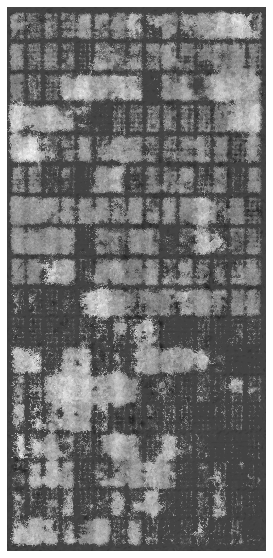

In [11]:
# Step 1: Perspective transform, turn the image to positive
chm_path = r"D:\shanghai_songjiang\190814\chm.tif"
RTK_information_path = r"C:\Users\Think\Desktop\test\RTK_information\s_mtps.shp"
dst_PT,columns_val,rows_val,columns_val_base,rows_val_base=transform(chm_path, RTK_information_path)

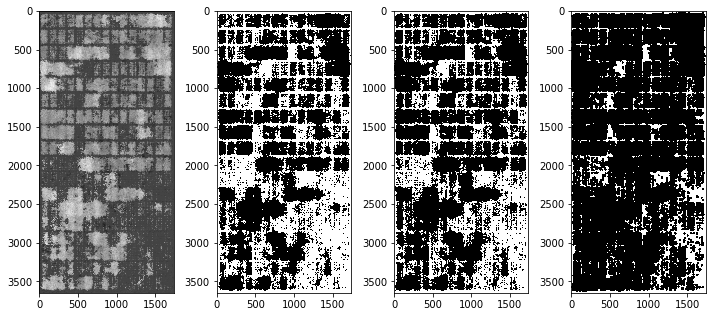

In [12]:
# Step 2: Binarization
ero_all = binaryzation(dst_PT)

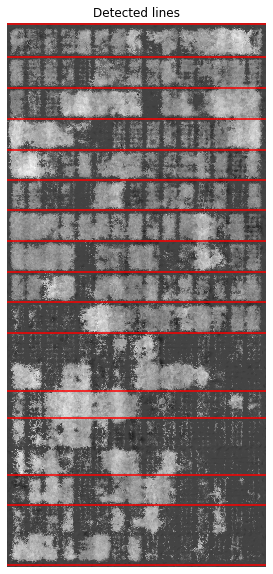

In [13]:
#Step 3: Detect and filter horizontal lines
hough_h_se,hor_cons_se = line_horizontal(dst_PT, ero_all)

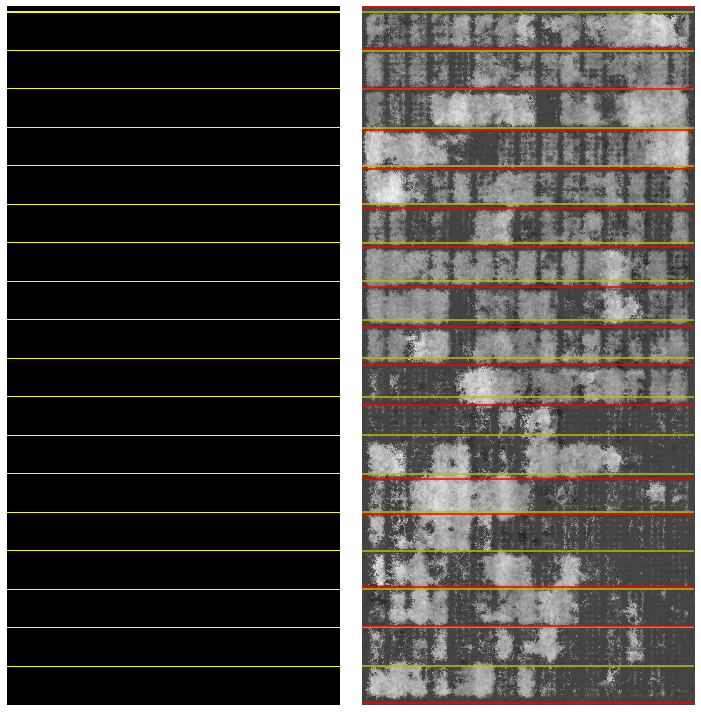

In [14]:
#Step 4: Add the horizontal base line
column_number = 18 #18行
h_line_base, hor_base=base_line_horizontal(dst_PT, hor_cons_se, column_number,columns_val_base)

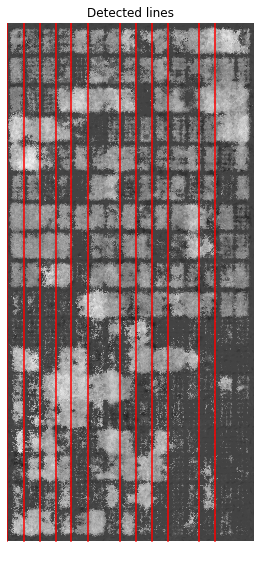

In [15]:
#Step 5: Check and filter the vertical lines
hough_v_se,ver_cons_se = line_vertical(dst_PT, ero_all)

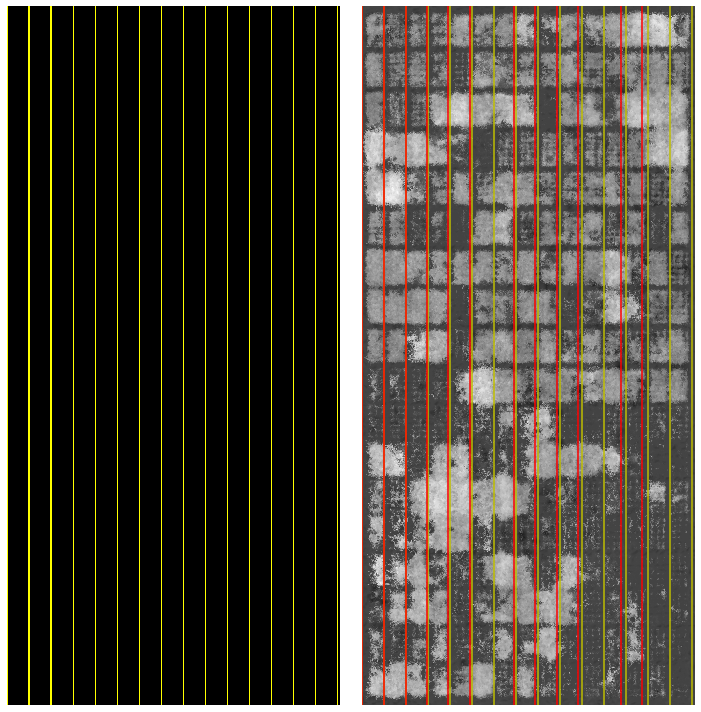

In [16]:
#Step 6: Add vertical baseline
row_number = 15 #15列
v_line_base, ver_base = base_line_vertical(dst_PT, ver_cons_se, row_number, rows_val_base)

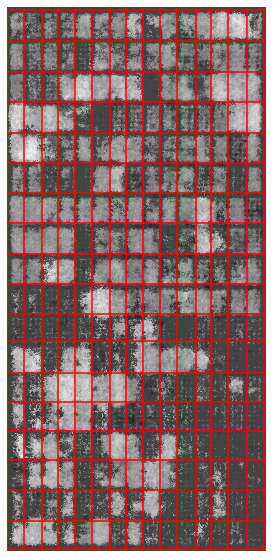

In [17]:
#Step 7: Merge all lines
all_line_mask=merge_all_line(hough_h_se, hough_v_se, h_line_base, v_line_base)

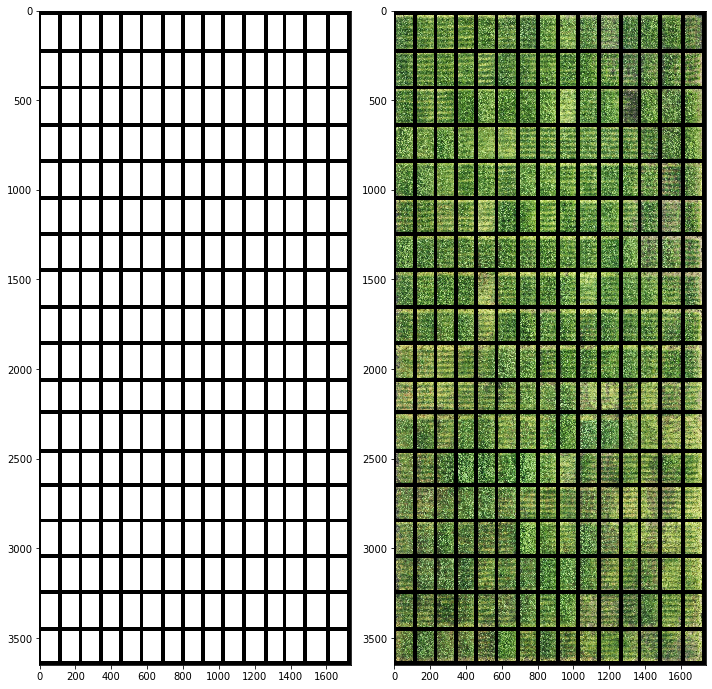

In [18]:
#Step 8: Make and visualize the mask
orthomosaic_path = r"D:\test_data\2D_orthomosaic_image\190814_s_transparent_mosaic_group1.tif"
mask_visualization(all_line_mask, RTK_information_path, columns_val, rows_val, orthomosaic_path)